<a href="https://colab.research.google.com/github/mto0501/Internetprojects/blob/main/Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Now upload the file "kaggle.json" file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hmto0501","key":"fcd149e7668b7efd45cd5c24dcf7c7cb"}'}

In [ ]:
# Install kaggle package
!pip install --upgrade --force-reinstall --no-deps kaggle

# Ensure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # set permission

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
# Use with option -p to choose the destination
!kaggle competitions download -c dog-breed-identification -p /content/gdrive/MyDrive/ML_PROJECTS

 99% 684M/691M [00:05<00:00, 157MB/s]
100% 691M/691M [00:05<00:00, 129MB/s]


In [150]:
import matplotlib.pyplot as plt
import numpy as np
import os, tarfile
import pathlib
import PIL
import tensorflow as tf
import pandas as pd
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
# Now you can Unzip it!
# !unzip -q <SOURCE-PATH> -d <DESTINATION-PATH>

!unzip -q /content/gdrive/MyDrive/ML_PROJECTS/dog_identification/dog-breed-identification.zip -d /content/gdrive/MyDrive/ML_PROJECTS/dog_identification

In [3]:
train_src = '/content/gdrive/MyDrive/ML_PROJECTS/dog_identification/train'
test_src = '/content/gdrive/MyDrive/ML_PROJECTS/dog_identification/test'

In [4]:
train_labels =  pd.read_csv('/content/gdrive/MyDrive/ML_PROJECTS/dog_identification/labels.csv', index_col = 'id')
submission= pd.read_csv('/content/gdrive/MyDrive/ML_PROJECTS/dog_identification/sample_submission.csv')

In [5]:
train_size = len(os.listdir(train_src))
test_size = len(os.listdir(test_src))

print(train_size,test_size)
print(train_labels.shape)
print(submission.shape)

10342 10357
(10222, 1)
(10357, 121)


In [6]:
target, dog_breeds = pd.factorize(train_labels['breed'], sort = True)
train_labels['target'] = target

print(dog_breeds)

Index(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller', 'australian_terrier',
       'basenji', 'basset', 'beagle',
       ...
       'toy_poodle', 'toy_terrier', 'vizsla', 'walker_hound', 'weimaraner',
       'welsh_springer_spaniel', 'west_highland_white_terrier', 'whippet',
       'wire-haired_fox_terrier', 'yorkshire_terrier'],
      dtype='object', length=120)


In [7]:
display(train_labels.head())
display(submission.head())

breed  target
id                                                        
000bec180eb18c7604dcecc8fe0dba07       boston_bull      19
001513dfcb2ffafc82cccf4d8bbaba97             dingo      37
001cdf01b096e06d78e9e5112d419397          pekinese      85
00214f311d5d2247d5dfe4fe24b2303d          bluetick      15
0021f9ceb3235effd7fcde7f7538ed62  golden_retriever      49

id  ...  yorkshire_terrier
0  000621fb3cbb32d8935728e48679680e  ...           0.008333
1  00102ee9d8eb90812350685311fe5890  ...           0.008333
2  0012a730dfa437f5f3613fb75efcd4ce  ...           0.008333
3  001510bc8570bbeee98c8d80c8a95ec1  ...           0.008333
4  001a5f3114548acdefa3d4da05474c2e  ...           0.008333

[5 rows x 121 columns]

In [8]:
train_labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
golden_retriever         67
komondor                 67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

In [9]:
data_dir = pathlib.Path("/content/gdrive/MyDrive/ML_PROJECTS/dog_data")
#data_dir.mkdir()

In [10]:
train_dir = pathlib.Path("/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train")
val_dir = pathlib.Path("/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train")
test_dir = pathlib.Path("/content/gdrive/MyDrive/ML_PROJECTS/dog_data/test/images")

#train_dir.mkdir()
#val_dir.mkdir()
#test_dir.mkdir()

In [ ]:
## Create a directory for each dog breed classes
for breed in dog_breeds:
    breed_dir = train_dir / breed
    breed_dir.mkdir()

In [ ]:
for root, dirs, files in os.walk(train_src):
    for file in files:
        imgName = file.split('.')[0]
        src_file = os.path.join(train_src, file)
        destination = os.path.join(train_dir, train_labels.loc[imgName, 'breed'])
        shutil.copy2(src_file, destination)

In [ ]:
shutil.copytree(test_src, test_dir / 'images')

PosixPath('/content/gdrive/MyDrive/ML_PROJECTS/dog_data/test/images')

In [11]:
data_dir = pathlib.Path("/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train")

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  shuffle=True,
  batch_size=32)

Found 10222 files belonging to 120 classes.
Using 8178 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  shuffle=False,
  batch_size=32)

Found 10222 files belonging to 120 classes.
Using 2044 files for validation.


In [50]:
train_ds = image_dataset_from_directory(
  directory = train_dir,
  labels = 'inferred',
  label_mode='int',
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle = True,
  seed=1234,
  validation_split=0.2,
  subset="training",
)

NameError: ignored

#Visualize the Data train and validation:

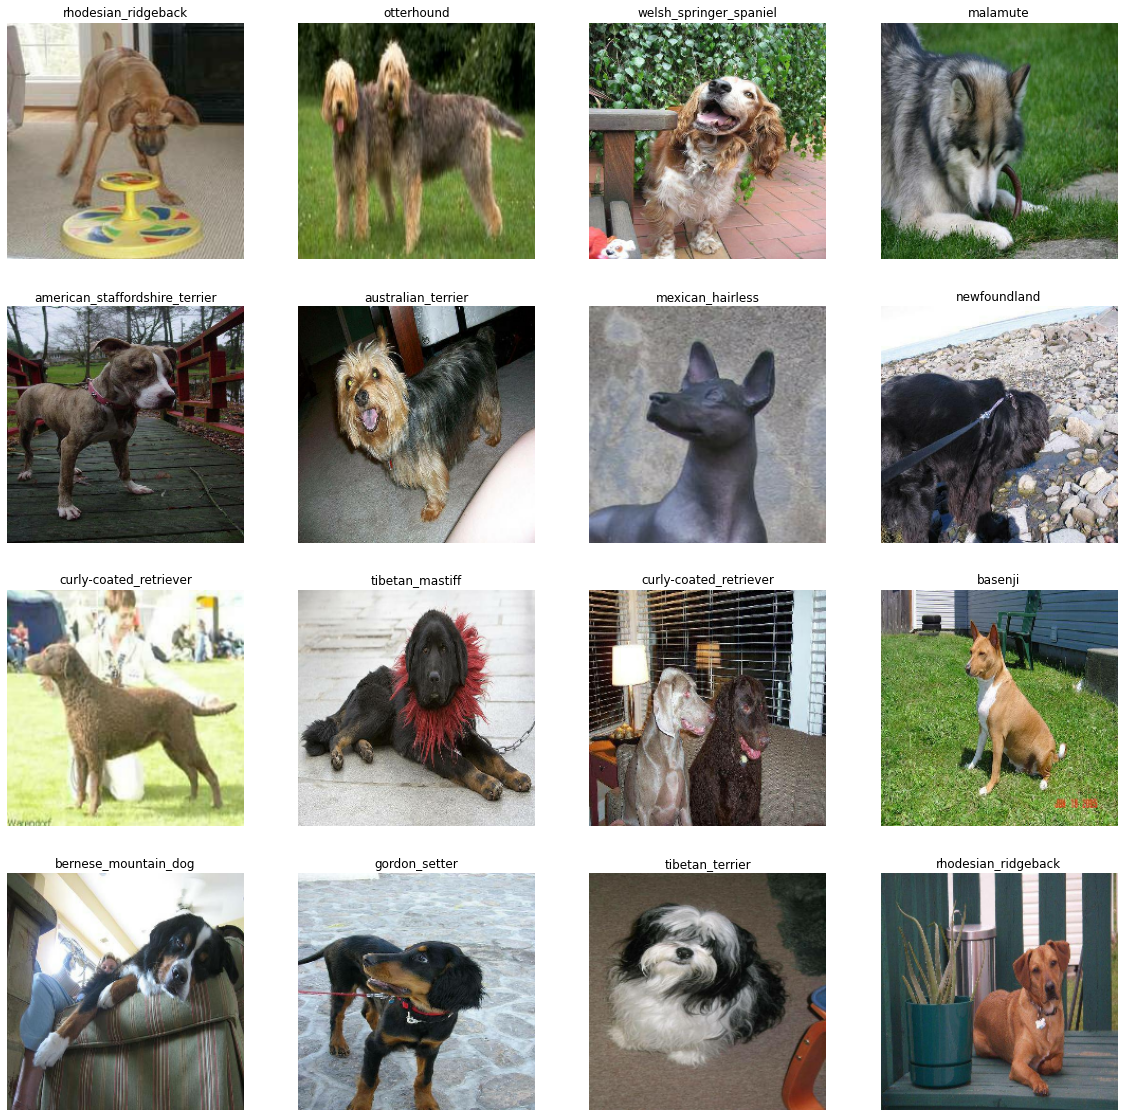

In [51]:
plt.figure(figsize=(20, 20))

for images, labels in train_ds.take(1):
#   print(labels)
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dog_breeds[labels[i]])
    plt.axis("off")

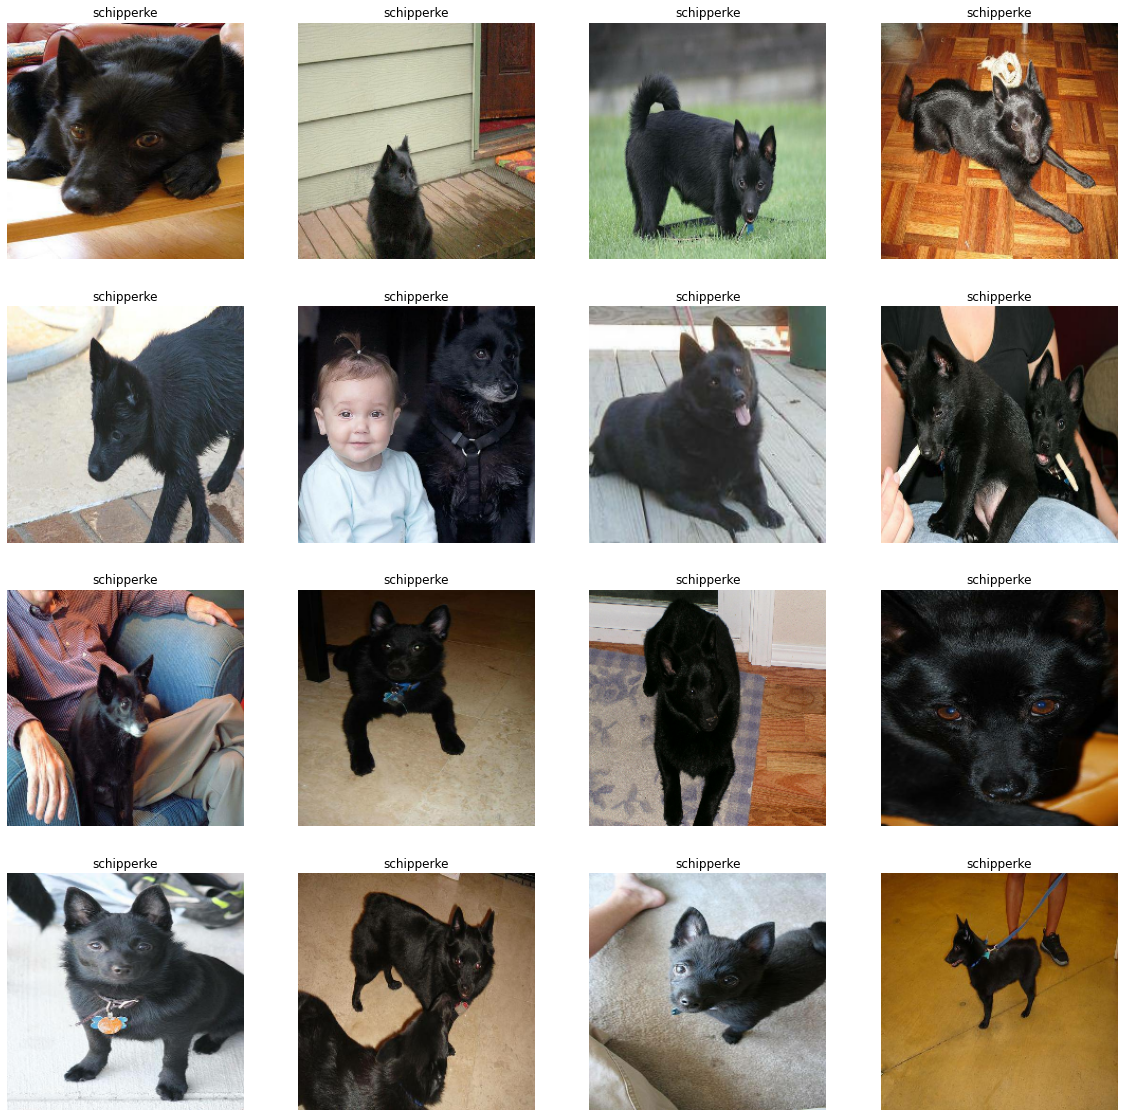

In [52]:
plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
#   print(labels)
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dog_breeds[labels[i]])
    plt.axis("off")

Configure the dataset for performance

Let's make sure to use buffered prefetching, so we can yield data from disk without having I/O become blocking. These are two important methods we should use when loading data.

.cache() keeps the images in memory after they're loaded off disk during the first epoch.

.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE) Code mẫu có làm test nhưng tui không xài

Keras ImageDataGenerator, Data augmentation 

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 299
BATCH_SIZE = 32
def generator_augmentation_maker():
  train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2)     # IMPORTANT
  
  val_gen = ImageDataGenerator(validation_split=0.2)  # IMPORTANT

  train_generator = train_gen.flow_from_directory(
          train_dir,  
          target_size=(IMG_SIZE,IMG_SIZE),  
          batch_size=32,
          class_mode='categorical',
          shuffle=True,
          seed=42,            # IMPORTANT
          subset='training')  # IMPORTANT

  validation_generator = val_gen.flow_from_directory(
          train_dir,
          target_size=(IMG_SIZE,IMG_SIZE),
          batch_size=32,
          class_mode='categorical',
          shuffle=False,        # IMPORTANT
          seed=42,              # IMPORTANT
          subset='validation')  # IMPORTANT
  return train_generator, validation_generator

In [17]:
train_generator, validation_generator = generator_augmentation_maker()

Found 8221 images belonging to 120 classes.
Found 2001 images belonging to 120 classes.


In [18]:
base_model = keras.applications.Xception(
                          weights="imagenet",
                          input_shape=(299, 299, 3), 
                          include_top=False)

base_model.trainable=False

83697664/83683744 [==============================] - 0s 0us/step


In [19]:
from keras.applications.xception import preprocess_input

def model_maker():
  inputs = keras.Input(shape=(299,299,3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(120, activation='softmax')(x)
  model = keras.Model(inputs, outputs)
  return model

In [20]:
model = model_maker()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [21]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 

callback = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)]

init_epochs=10

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=init_epochs,
                    callbacks = callback)

Epoch 1/10
257/257 [==============================] - 3139s 12s/step - loss: 1.6245 - accuracy: 0.6806 - val_loss: 0.4902 - val_accuracy: 0.8881 - lr: 0.0010
Epoch 2/10
257/257 [==============================] - 190s 740ms/step - loss: 0.6079 - accuracy: 0.8335 - val_loss: 0.3757 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 3/10
257/257 [==============================] - 190s 737ms/step - loss: 0.5189 - accuracy: 0.8490 - val_loss: 0.3469 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 4/10
257/257 [==============================] - 189s 737ms/step - loss: 0.4605 - accuracy: 0.8634 - val_loss: 0.3299 - val_accuracy: 0.8951 - lr: 0.0010
Epoch 5/10
257/257 [==============================] - 190s 740ms/step - loss: 0.4266 - accuracy: 0.8697 - val_loss: 0.3223 - val_accuracy: 0.8926 - lr: 0.0010
Epoch 6/10
257/257 [==============================] - 190s 738ms/step - loss: 0.3982 - accuracy: 0.8758 - val_loss: 0.3231 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 7/10
257/257 [===========================

In [26]:
model.evaluate(validation_generator)

63/63 [==============================] - 12s 186ms/step - loss: 0.3214 - accuracy: 0.9015


[0.32140564918518066, 0.901549220085144]

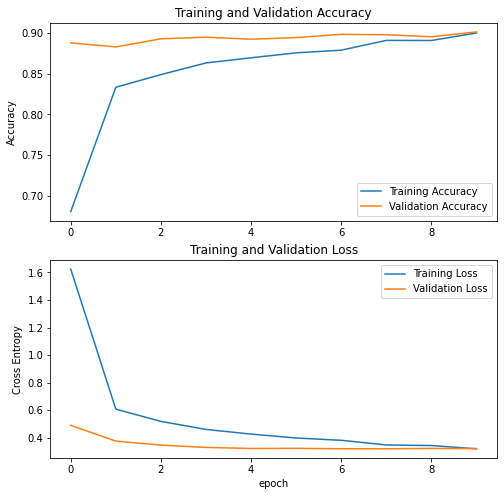

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine-tuning

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [29]:
# Unfreeze the base_model.
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 127

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # default 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [31]:
#!mkdir -p "/content/gdrive/MyDrive/ML_PROJECTS/dog_data/Results"
#!mkdir -p "/content/gdrive/MyDrive/ML_PROJECTS/dog_data/Results"
RESULT            =  pathlib.Path("/content/gdrive/MyDrive/ML_PROJECTS/dog_data/Results")
SAVED_MODEL       =  pathlib.Path("/content/gdrive/MyDrive/ML_PROJECTS/dog_data/Results")

In [32]:
# CALLBACK and TRAIN

# Stopped by EarlyStopping: model is auto-restored best weights => can CONTINUE to finetune
# Stopped by user => LOAD model_ckpt to continue
# Stopped by finishing => model saved to Saved_model

from keras.callbacks import ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
             ModelCheckpoint(monitor='val_loss', filepath=RESULT/'model_ckpt11272021.h5', save_weights_only=False, save_best_only=True, verbose=1)]

init_epochs = 10
fine_tune_epochs = 10
total_epochs = init_epochs + fine_tune_epochs

history_fine = model.fit(train_generator, 
                         validation_data=validation_generator,
                         epochs=total_epochs,
                         initial_epoch=init_epochs,
                         callbacks=callbacks)

model.save(SAVED_MODEL)

Epoch 11/20
257/257 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.9088
Epoch 00011: val_loss improved from inf to 0.31209, saving model to /content/gdrive/MyDrive/ML_PROJECTS/dog_data/Results/model_ckpt11272021.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


257/257 [==============================] - 194s 744ms/step - loss: 0.2822 - accuracy: 0.9088 - val_loss: 0.3121 - val_accuracy: 0.9010
Epoch 12/20
257/257 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.9155
Epoch 00012: val_loss improved from 0.31209 to 0.30950, saving model to /content/gdrive/MyDrive/ML_PROJECTS/dog_data/Results/model_ckpt11272021.h5
257/257 [==============================] - 192s 746ms/step - loss: 0.2712 - accuracy: 0.9155 - val_loss: 0.3095 - val_accuracy: 0.9030
Epoch 13/20
257/257 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.9152
Epoch 00013: val_loss improved from 0.30950 to 0.30810, saving model to /content/gdrive/MyDrive/ML_PROJECTS/dog_data/Results/model_ckpt11272021.h5
257/257 [==============================] - 195s 757ms/step - loss: 0.2568 - accuracy: 0.9152 - val_loss: 0.3081 - val_accuracy: 0.9020
Epoch 14/20
257/257 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.9157
Epoch 0001

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [33]:
model.evaluate(validation_generator)

63/63 [==============================] - 12s 189ms/step - loss: 0.3081 - accuracy: 0.9020


[0.30809611082077026, 0.9020490050315857]

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

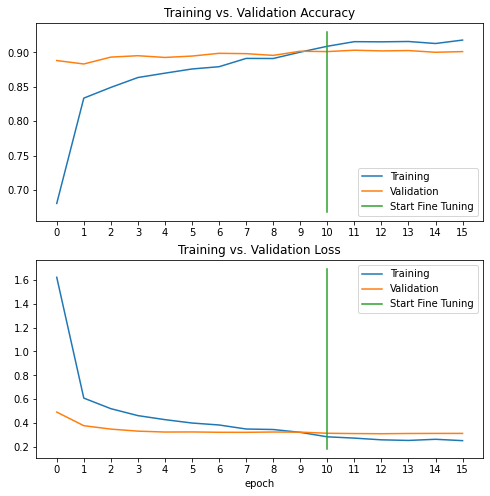

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0.9, 1])
plt.plot([init_epochs,init_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training vs. Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([init_epochs,init_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training vs. Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
from google.colab import files
# UPLOAD A PHOTO and PREDICT
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  img_path = './' + fn

Saving Pembroke-Welsh-Corgi.jpg to Pembroke-Welsh-Corgi.jpg
Pembroke-Welsh-Corgi.jpg


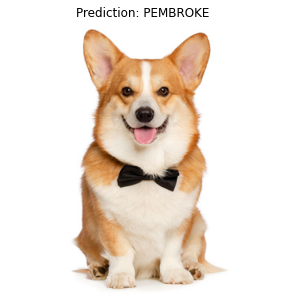

In [37]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

img        = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array  = image.img_to_array(img)
img_array  = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

for key, value in validation_generator.class_indices.items():
  if value == prediction[0].argmax(): # argmax -> index
    pred = key

plt.figure(figsize=(5,5))
img = mpimg.imread(img_path)
plt.imshow(img)
plt.title('Prediction: ' + pred.upper()) #label predicted
plt.axis('off')
plt.grid(b=None)
plt.show()

###Model evaluation

In [38]:
validation_generator.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [39]:
ground_truth = validation_generator.classes
ground_truth[:]

array([  0,   0,   0, ..., 119, 119, 119], dtype=int32)

In [40]:
filenames = validation_generator.filenames
filenames

['affenpinscher/00ca18751837cd6a22813f8e221f7819.jpg',
 'affenpinscher/01268f0007876a692907bda89468184c.jpg',
 'affenpinscher/0162107acd8f2588c0944b791d61bb0c.jpg',
 'affenpinscher/040fef64640b89c53f161b6c5215b78b.jpg',
 'affenpinscher/0484a6cc686a07e1edacd0fb44b1d965.jpg',
 'affenpinscher/100f347ec78a42a9e7c2418e4beb3f6a.jpg',
 'affenpinscher/106d7e0df869e7ba9f6d16c5f77ddfb8.jpg',
 'affenpinscher/10edc6f98c2423e4e195e09a86b0d292.jpg',
 'affenpinscher/11b60d8d86f14a601ca290909a17cbc6.jpg',
 'affenpinscher/18b4e732c105272f40956c2f85813bcb.jpg',
 'affenpinscher/19a8c1698819d382c3ead14bdc1a360b.jpg',
 'affenpinscher/19de1db12b3ddc7f2af6d9453c977083.jpg',
 'affenpinscher/1a012faf98b32039adc17ee708bcb360.jpg',
 'affenpinscher/1aa98488ce65f9b57b468ccde4f1cad8.jpg',
 'affenpinscher/1ee0c041d15647e3909625eba419f153.jpg',
 'affenpinscher/20430175869defec1722d3432f42ebd7.jpg',
 'afghan_hound/0379145880ad3978f9b80f0dc2c03fba.jpg',
 'afghan_hound/059a86d50634c78d5a18f918cb0b3f0d.jpg',
 'afghan_hou

In [42]:
val_dir 

PosixPath('/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train')

In [44]:
predictions = model.predict(validation_generator)
pred_indices = np.argmax(predictions,axis=1)

img_paths = list(map(lambda x: str(val_dir/x), filenames))  

In [45]:
ground_truth[:5] , img_paths[:5]

(array([0, 0, 0, 0, 0], dtype=int32),
 ['/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/affenpinscher/00ca18751837cd6a22813f8e221f7819.jpg',
  '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/affenpinscher/01268f0007876a692907bda89468184c.jpg',
  '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/affenpinscher/0162107acd8f2588c0944b791d61bb0c.jpg',
  '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/affenpinscher/040fef64640b89c53f161b6c5215b78b.jpg',
  '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/affenpinscher/0484a6cc686a07e1edacd0fb44b1d965.jpg'])

In [46]:
from sklearn.metrics import classification_report

print(classification_report(ground_truth, pred_indices, target_names=list(validation_generator.class_indices.keys())))

                                precision    recall  f1-score   support

                 affenpinscher       0.88      0.88      0.88        16
                  afghan_hound       0.96      1.00      0.98        23
           african_hunting_dog       1.00      1.00      1.00        17
                      airedale       0.91      0.95      0.93        21
american_staffordshire_terrier       0.64      1.00      0.78        14
                   appenzeller       0.85      0.73      0.79        15
            australian_terrier       0.77      0.85      0.81        20
                       basenji       1.00      0.86      0.93        22
                        basset       0.94      1.00      0.97        16
                        beagle       0.77      0.95      0.85        21
            bedlington_terrier       1.00      0.94      0.97        17
          bernese_mountain_dog       1.00      0.95      0.98        22
       black-and-tan_coonhound       0.92      0.80      0.86  

###Error analysis sample:

In [47]:
print(validation_generator.class_indices)

{'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 'german_short-haired_pointer': 47, 'gian

In [48]:
filenames = validation_generator.filenames
print(len(filenames))
print(filenames[500:505], '\n')

ground_truth = validation_generator.classes
print(len(ground_truth))
ground_truth

2001
['chihuahua/146fcb253fd7b73b2c9f20d91a49f400.jpg', 'chihuahua/151474b992b295f69547839e31271dd0.jpg', 'chihuahua/164c3b823c400cea20ad0a3426e1eeea.jpg', 'chihuahua/17f69b6a170c33a8786d566f6dc9b8d5.jpg', 'chihuahua/1adf573efd5f90c4b11be12afbf66e3d.jpg'] 

2001


array([  0,   0,   0, ..., 119, 119, 119], dtype=int32)

In [49]:
# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    # get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability, 
                               index_of_highest_probability, 
                               ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)


In [53]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(str(val_dir) + '/' + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

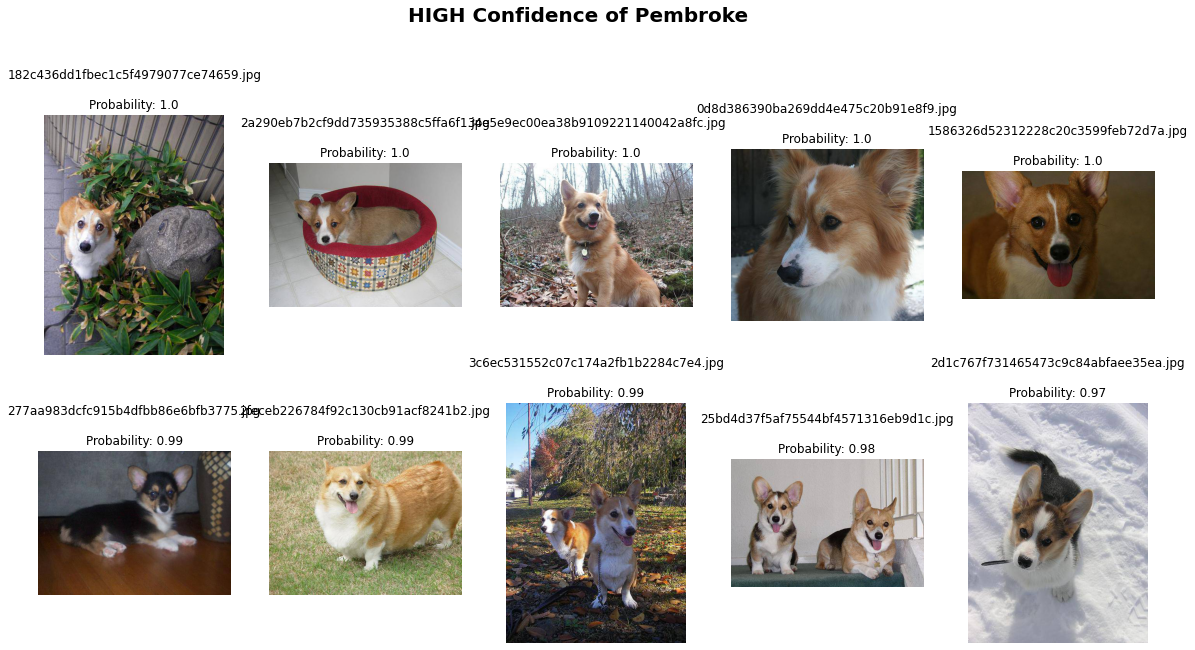

In [54]:
message = 'HIGH Confidence of Pembroke'
highest_confident_pembroke_images = get_images_with_sorted_probabilities(prediction_table, True, 86, 10, False)
display(highest_confident_pembroke_images, message) 

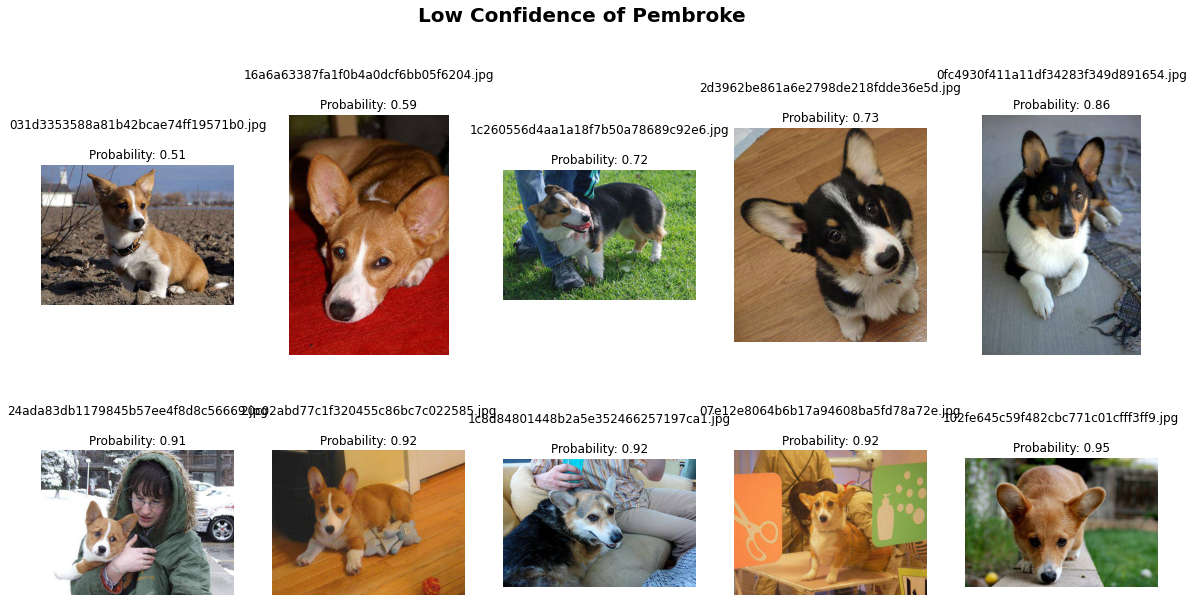

In [55]:
message = 'Low Confidence of Pembroke'
lowest_confident_pembroke_images = get_images_with_sorted_probabilities(prediction_table, False, 86, 10, False)
display(lowest_confident_pembroke_images, message) 
plt.show()

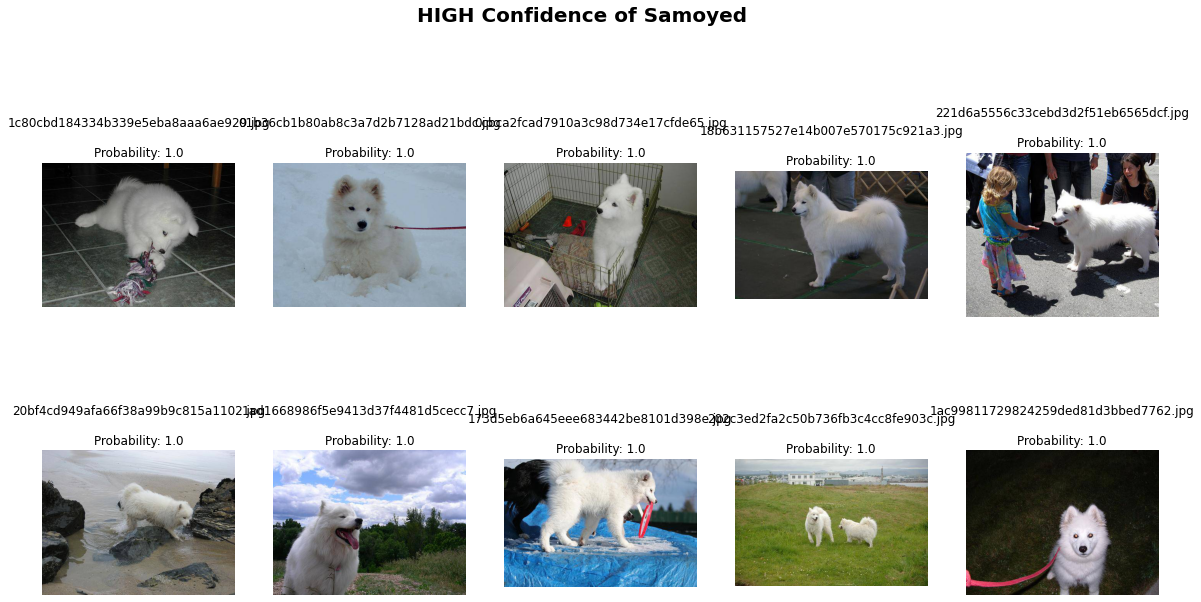

In [57]:
message = 'HIGH Confidence of Samoyed'
highest_confident_samoyed_images = get_images_with_sorted_probabilities(prediction_table, True, 94, 10, False)
display(highest_confident_samoyed_images, message) 

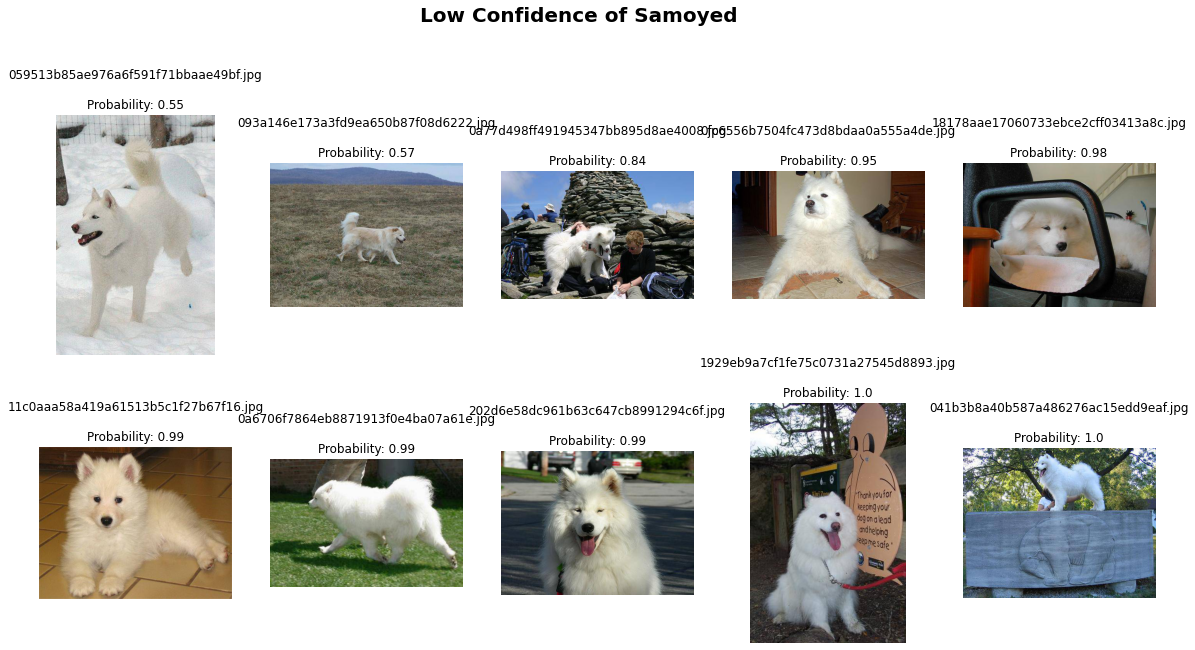

In [58]:
message = 'Low Confidence of Samoyed'
lowest_confident_samoyed_images = get_images_with_sorted_probabilities(prediction_table, False, 94, 10, False)
display(lowest_confident_samoyed_images, message) 
plt.show()

##PREPARE FOR GRADCAM

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

import os
import shutil   
import zipfile

In [154]:
# plotting functions
def get_img_array(img_path, img_size):
    # `img` is a PIL image
    img = keras.preprocessing.image.load_img(img_path, target_size=(img_size,img_size)) # load and resize
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    # array = preprocess_input(array)     # comment this line if model includes a preprocessing layer
    return array

def plot_image_with_pred(img_path, model, labels, img_size=299):
    # display part
    img = Image.open(img_path)
    img =  img.resize((img_size,img_size))   # resize to mimic model's input
    img = np.array(img)
    plt.imshow(img)
    # prediction part
    img_array = get_img_array(img_path, img_size)
    preds = model.predict(img_array)
    plt.title(f'Prediction: {labels[preds.argmax(axis=1)[0]]}, with {round(preds.max()*100,2)}%')
    return img_array

In [155]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names, base_model_idx, pretrained=True):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    if pretrained:
        last_conv_layer = model.layers[base_model_idx].get_layer(last_conv_layer_name)
        last_conv_layer_model = keras.Model(model.layers[base_model_idx].inputs, last_conv_layer.output)
    else:
        last_conv_layer = model.get_layer(last_conv_layer_name)
        last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

        
    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    
    for layer_name in classifier_layer_names:
      try:
          x = model.get_layer(layer_name)(x)
      except:
          x = model.layers[base_model_idx].get_layer(layer_name)(x)  
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index] # the f function

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# We load the original image
def plot_with_heatmap(img_path, heatmap, img_size=299):
    img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
    img = keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap  + img*0.6
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    fig, axes = plt.subplots(2, 1, figsize=(10,10))
    step = img_size//7
    axes[0].set_xticks([x*step for x in range(1,7)])
    axes[0].set_yticks([x*step for x in range(1,7)])
    axes[0].imshow(jet_heatmap.astype(int))
    axes[1].set_xticks([x*step for x in range(1,7)])
    axes[0].set_yticks([x*step for x in range(1,7)])
    axes[1].imshow(superimposed_img)
    

In [156]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [157]:
model.layers[3].summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

Now we can see that the last Conv layer is at index -3. We can print out to check!

In [158]:
model.layers[3].layers[-5:]

In [159]:
# IMPORTANT
base_model_idx = 3  # <<<<<
last_conv_idx = -3  # <<<<<

last_conv_layer_name = model.layers[base_model_idx].layers[last_conv_idx].name # destination layer
the_rest_names = [i.name for i in model.layers[base_model_idx].layers[last_conv_idx+1:]] + [j.name for j in model.layers[(base_model_idx+1):]]

# CHECK
print(last_conv_layer_name, '\n')
print(the_rest_names)

block14_sepconv2 

['block14_sepconv2_bn', 'block14_sepconv2_act', 'global_average_pooling2d', 'dropout', 'dense']


In [160]:
def display_everything(path, last_conv_layer_name, the_rest_names, base_model_idx):
  img_path = path
  
  img_array = plot_image_with_pred(img_path, model,labels=list(train_generator.class_indices.keys()))
  
  heatmap = make_gradcam_heatmap(img_array, model, 
                                last_conv_layer_name, 
                                the_rest_names,
                                base_model_idx)
  
  plot_with_heatmap(img_path,heatmap)

In [161]:
filenames = validation_generator.filenames
img_paths = list(map(lambda x: str(val_dir/x), filenames))  # Full path

In [162]:
predictions = model.predict(validation_generator)
pred_indices = np.argmax(predictions,axis=1)

ground_truth = validation_generator.classes

wrong_pred_paths = np.array(img_paths)[(pred_indices != ground_truth)]

print("Total wrong predictions:", len(wrong_pred_paths), '\n')
wrong_pred_paths

Total wrong predictions: 196 



array(['/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/affenpinscher/11b60d8d86f14a601ca290909a17cbc6.jpg',
       '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/affenpinscher/20430175869defec1722d3432f42ebd7.jpg',
       '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/airedale/292027eeb86ebe99f9f00ad02697dcec.jpg',
       '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/appenzeller/05fbe54802ffb6d6256abb93381f5cf4.jpg',
       '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/appenzeller/0fd8e587dd02713551fc1fb0c8841c49.jpg',
       '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/appenzeller/1e157be5512667b3f4476253f0acf333.jpg',
       '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/appenzeller/1ef5e8db93701b28e1203ecd7e1baf37.jpg',
       '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/australian_terrier/0dc45e3e57bbcfccc550479d57b39951.jpg',
       '/content/gdrive/MyDrive/ML_PROJECTS/dog_data/train/australian_terrier/2a586995ffa57d8f693241ca833c9376.j

In [163]:
def plot_images(img_paths, message, img_size=299):
    plt.figure(figsize=(60, 60))
    columns = 5
    for i, img_path in enumerate(img_paths):
        # predict
        img_array = get_img_array(img_path, img_size)
        predictions = model.predict(img_array)

        # setup
        ax = plt.subplot(len(img_paths) / columns + 1, columns, i + 1)
        ax.set_title(img_paths[i].split("/")[-1] + "\n" +
                     "\nProbability: " + str(float("{0:.1f}".format(predictions.max()*100))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        
        # show
        img = Image.open(img_path)
        img = np.array(img)
        plt.imshow(img)

In [164]:
plot_images(wrong_pred_paths, "Wrong predictions")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [165]:
heatmap = display_everything(wrong_pred_paths[2], last_conv_layer_name, the_rest_names, base_model_idx)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [166]:
img_path = "/content/Pembroke-Welsh-Corgi.jpg"
print(img_path, '\n')

display_everything(img_path, last_conv_layer_name, the_rest_names, base_model_idx)

/content/Pembroke-Welsh-Corgi.jpg 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>